# Data preprocessing

## emotion label + path to file

In [1]:
import pandas as pd
import numpy as np
import os

path_to_data='../data/emovo/'
imgs_path='../imgs/emovo/'
models_path='../models/emovo/'

def load_data(path):
    emotion, file_path, speaker_id = [], [], []
    
    # iterate over audio files and extract path, emotion label and actor id
    for root, _, files in os.walk(path_to_data):
        for filename in files:
            emotion.append(filename.split('-')[0])
            speaker_id.append(os.path.basename(root))
            file_path.append(os.path.join(root, filename))
                
    # prepare dataframe
    audio_df = pd.DataFrame(emotion)
    audio_df = audio_df.replace({'neu': 'neutral', 'dis': 'disgust', 'gio': 'happiness',
                                 'rab': 'anger', 'sor': 'surprise', 'tri': 'sadness', 'pau': 'fear'})
    
    # concatenate file paths to emotion data frame
    audio_df = pd.concat([pd.DataFrame(file_path), pd.DataFrame(speaker_id), audio_df], axis=1)
    audio_df.columns = ['path', 'speaker', 'emotion']
    
    return audio_df

df = load_data(path_to_data)
df

,path,speaker,emotion
0,../data/emovo/f3/sor-f3-b1.wav,f3,surprise
1,../data/emovo/f3/gio-f3-l1.wav,f3,happiness
2,../data/emovo/f3/tri-f3-n4.wav,f3,sadness
3,../data/emovo/f3/tri-f3-d2.wav,f3,sadness
4,../data/emovo/f3/pau-f3-l2.wav,f3,fear
...,...,...,...
583,../data/emovo/m3/gio-m3-l1.wav,m3,happiness
584,../data/emovo/m3/rab-m3-l3.wav,m3,anger
585,../data/emovo/m3/sor-m3-l4.wav,m3,surprise
586,../data/emovo/m3/sor-m3-l1.wav,m3,surprise


# Plots

## class distribution

['surprise' 'happiness' 'sadness' 'fear' 'neutral' 'anger' 'disgust']


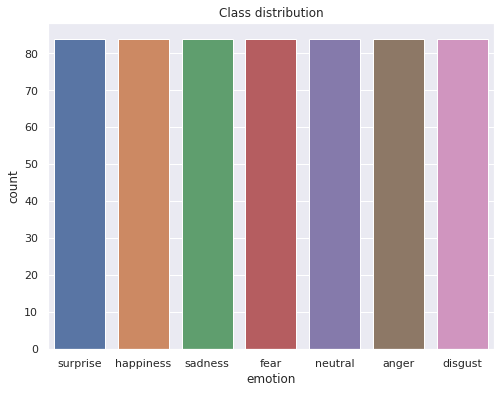

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
def class_imbalance_plot():
    print(df['emotion'].unique())
    sns.set_theme(style='darkgrid')
    plt.figure(figsize = (8,6))
    sns.countplot(x = 'emotion', data = df)
    plt.title('Class distribution')
    plt.savefig(imgs_path + 'class_distribution.png')
    plt.show()
    return

class_imbalance_plot()

## waveform

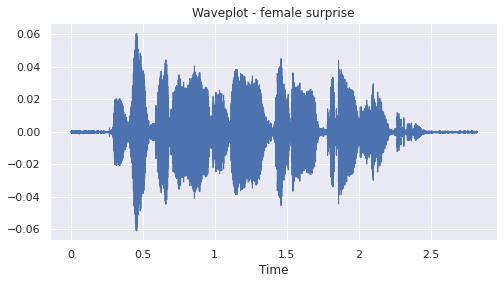

In [11]:
import librosa.display

# waveplot
wavf, sr = librosa.load(df['path'][0])

plt.figure(figsize = (8, 4))
librosa.display.waveshow(wavf, sr = sr)
plt.title('Waveplot - female surprise')
plt.savefig(imgs_path + 'waveplot_female_surprise.png')
plt.show()

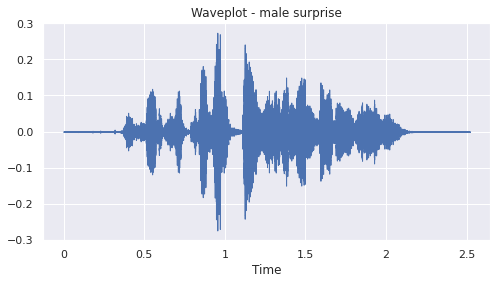

In [12]:
import librosa.display

# waveplot
wavf, sr = librosa.load(df["path"][587])

plt.figure(figsize = (8, 4))
librosa.display.waveshow(wavf, sr = sr)
plt.title('Waveplot - male surprise')
plt.savefig(imgs_path + 'waveplot_male_surprise.png')
plt.show()

# Feature extraction

- [mfcc extraction info](https://www.researchgate.net/profile/Teddy-Gunawan/publication/353296706_Speech_Emotion_Recognition_Using_Feature_Fusion_of_TEO_and_MFCC_on_Multilingual_Databases/links/613ef96f4e1df2710631ca0a/Speech-Emotion-Recognition-Using-Feature-Fusion-of-TEO-and-MFCC-on-Multilingual-Databases.pdf)
- [librosa docs](https://librosa.org/doc/latest/index.html)

In [14]:
import librosa

# log-mel spectrogram into mfcc

logMelSpecVal = []

def parse_audio_file(pathToFile, _sr, _duration):
    # load file
    wavf, sample_rate = librosa.load(pathToFile, res_type='kaiser_fast', duration=_duration, sr=_sr)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 44100, 3)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,speaker,emotion,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,f3,surprise,-38.955906,-36.908241,-37.528881,-37.221275,-38.663319,-38.391434,-40.557957,-40.268555,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,f3,happiness,-42.716454,-40.996956,-42.391411,-39.358833,-39.177368,-40.242924,-39.661491,-38.096584,...,-34.553543,-34.852371,-33.706364,-31.785057,-20.235243,-16.568151,-18.537838,-24.118795,-20.983976,-15.738373
2,f3,sadness,-45.679428,-44.072655,-43.396301,-44.770939,-45.598980,-45.521084,-44.709785,-44.854473,...,-29.435818,-30.807732,-33.917229,-35.166691,-32.878994,-33.314793,-35.450275,-34.499554,-33.619106,-34.642258
3,f3,sadness,-46.623066,-45.496864,-44.627197,-44.194084,-44.737774,-44.918907,-42.773659,-42.659634,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,f3,fear,-41.082657,-38.237114,-37.361401,-36.033562,-38.975845,-38.514137,-39.332222,-40.533066,...,-34.174515,-34.790878,-34.847382,-34.247585,-31.258413,-28.683655,-27.390999,-28.509367,-29.792696,-31.349588


# Data split

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def data_split(df):
    # stratified train, test split
    train, test = train_test_split(df, test_size=0.2,random_state=0, stratify=df[['emotion', 'speaker']])
    
    # divide data into labels and features
    X = df.iloc[:, :].drop(columns=['emotion'])
    y = df['emotion']
    
    X_train = train.iloc[:, :].drop(columns=['emotion', 'speaker'])
    y_train = train['emotion']
    
    X_test = test.iloc[:, :].drop(columns=['emotion', 'speaker'])
    y_test = test['emotion']
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(df)

print(X_train.head())
print(y_train.head())

           0          1          2          3          4          5    \
98  -44.223812 -44.223812 -44.223812 -44.223812 -44.223812 -44.223812   
417 -45.787804 -46.093666 -46.766670 -46.959263 -46.347702 -45.186592   
66  -49.131004 -49.546890 -49.546715 -50.840878 -50.999393 -50.631535   
366 -45.695778 -44.951332 -45.117371 -45.495308 -45.112099 -44.943279   
239 -29.326191 -28.636923 -29.101320 -29.002422 -29.531635 -30.523542   

           6          7          8          9    ...        249        250  \
98  -44.223812 -44.223812 -44.223812 -44.223812  ... -44.223812   0.000000   
417 -45.492455 -46.125916 -45.996750 -46.594894  ...   0.000000   0.000000   
66  -51.429989 -49.082634 -41.856655 -39.383873  ...   0.000000   0.000000   
366 -45.461136 -46.565231 -45.330154 -44.388794  ... -16.326618 -16.463198   
239 -33.643246 -34.777237 -35.873760 -33.518963  ...   0.000000   0.000000   

           251        252        253       254        255        256  \
98    0.000000   0.0

# Data preparation and normalization

In [16]:
from keras.utils import to_categorical

def data_preprocessing(X_train, X_test, y_train, y_test):

    # normalization (z-score, values between -1 and 1)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std

    # turn data into arrays for keras
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(y_train.shape)
    print(y_test.shape)

    # label one hot encoding
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_test = to_categorical(lb.fit_transform(y_test))

    print(y_test[0:3])

    print(lb.classes_)

    # data reshaping
    X_train = X_train[:,:,np.newaxis]
    X_test = X_test[:,:,np.newaxis]

    print(X_train.shape)
    
    return X_train, X_test, y_train, y_test, lb

X_train, X_test, y_train, y_test, lb = data_preprocessing(X_train, X_test, y_train, y_test)

2022-04-08 16:29:07.362482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(470,)
(118,)
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness' 'surprise']
(470, 259, 1)


# Model architecture

- [model architecture info](https://www.researchgate.net/profile/Gregor-Hofer-3/publication/335829168_Analysis_of_Deep_Learning_Architectures_for_Cross-Corpus_Speech_Emotion_Recognition/links/5e2f0a2f4585152d156d9f4f/Analysis-of-Deep-Learning-Architectures-for-Cross-Corpus-Speech-Emotion-Recognition.pdf)

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.regularizers import l2

def get_model():
    #BUILD 1D CNN LAYERS
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(7, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    
    return model

model = get_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 250, 64)           704       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 128)           

# Model training and export


Epoch 00001: val_accuracy improved from -inf to 0.21186, saving model to ../models/emovo/model_1_CNN
INFO:tensorflow:Assets written to: ../models/emovo/model_1_CNN/assets

Epoch 00002: val_accuracy did not improve from 0.21186

Epoch 00003: val_accuracy did not improve from 0.21186

Epoch 00004: val_accuracy did not improve from 0.21186

Epoch 00005: val_accuracy did not improve from 0.21186

Epoch 00006: val_accuracy did not improve from 0.21186

Epoch 00007: val_accuracy did not improve from 0.21186

Epoch 00008: val_accuracy improved from 0.21186 to 0.22034, saving model to ../models/emovo/model_1_CNN
INFO:tensorflow:Assets written to: ../models/emovo/model_1_CNN/assets

Epoch 00009: val_accuracy improved from 0.22034 to 0.23729, saving model to ../models/emovo/model_1_CNN
INFO:tensorflow:Assets written to: ../models/emovo/model_1_CNN/assets

Epoch 00010: val_accuracy did not improve from 0.23729

Epoch 00011: val_accuracy did not improve from 0.23729

Epoch 00012: val_accuracy imp

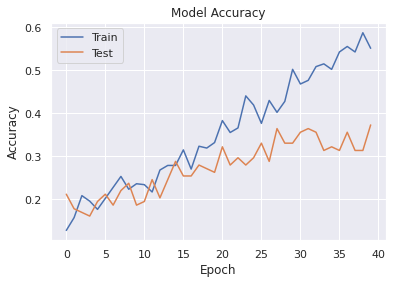

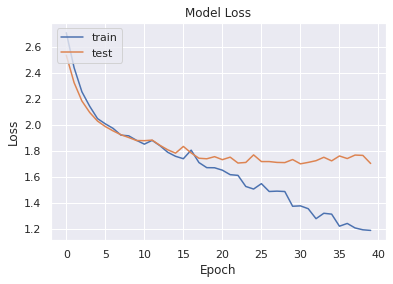

In [27]:
from keras.callbacks import ModelCheckpoint

# use checkpoints to save best model
checkpoint = ModelCheckpoint(models_path + 'model_1_CNN', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# fit model
model_history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=0)

# plot model accuracy and loss over epochs
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(imgs_path + 'Initial_Model_Accuracy.png')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(imgs_path + 'Initial_Model_loss.png')
plt.show()

# Results

## accuracy and loss

In [28]:
# loss and accuracy percentage on test set
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

4/4 [==============================] - 0s 2ms/step - loss: 1.7025 - accuracy: 0.3729
Loss of the model is -  1.7025418281555176
4/4 [==============================] - 0s 2ms/step - loss: 1.7025 - accuracy: 0.3729
Accuracy of the model is -  37.288135290145874 %


In [29]:
# predictions
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,fear,sadness
2,fear,fear
3,neutral,anger
4,surprise,surprise
5,fear,disgust
6,anger,anger
7,happiness,sadness
8,surprise,sadness
9,neutral,anger


## confusion matrix

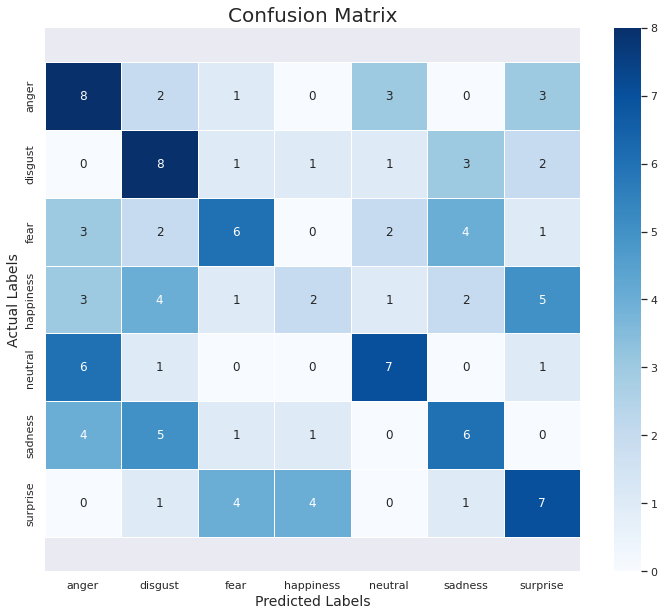

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgs_path + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [32]:
print(classification_report(actual, predictions, target_names = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']))

              precision    recall  f1-score   support

       anger       0.33      0.47      0.39        17
     disgust       0.35      0.50      0.41        16
        fear       0.43      0.33      0.38        18
   happiness       0.25      0.11      0.15        18
     neutral       0.50      0.47      0.48        15
     sadness       0.38      0.35      0.36        17
    surprise       0.37      0.41      0.39        17

    accuracy                           0.37       118
   macro avg       0.37      0.38      0.37       118
weighted avg       0.37      0.37      0.36       118

